# Library

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.layers import Dense, SimpleRNN, Embedding, GRU, Attention
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')

# Read and processing time series

In [ ]:
df = pd.read_csv('/content/X.csv')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-09-29,432.588074,436.787964,407.388763,432.588074,304.904572,76180670.0
1,2005-09-30,457.787384,457.787384,432.588074,457.787384,322.666016,105493978.0
2,2005-10-03,470.387024,474.586914,440.987854,470.387024,331.546692,59712955.0
3,2005-10-04,474.586914,482.986694,466.187164,474.586914,334.506927,56236668.0
4,2005-10-05,482.986694,482.986694,466.187164,482.986694,340.427429,31319315.0


In [ ]:
#Convert to datetime dtype
df['Date_new'] = pd.to_datetime(df['Date']).dt.normalize()

#drop columns
df = df.drop(columns=['Date'])
df = df.rename(columns={'Date_new':'Date'})
df = df.sort_values('Date').reset_index(drop=True)

#clean data
price  = df[['Close']].copy()
price.head()

,Close
0,432.588074
1,457.787384
2,470.387024
3,474.586914
4,482.986694


In [ ]:
#Scaling
scaler = MinMaxScaler()
scaled_price = scaler.fit_transform(price)
scaled_price

array([[0.03681223],
       [0.04318393],
       [0.04636977],
       ...,
       [0.58484659],
       [0.53933323],
       [0.51657656]])

In [ ]:
#Create dataset function using window size = 5, horizon = 1
window = 5
horizon = 1

def create_dataset(dataset, window = window, horizon = horizon):
  X, y = [], []
  for i in range(len(dataset) - window - horizon + 1):
    a = dataset[i:(i + window), 0]
    X.append(a)
    y.append(dataset[i + window + horizon - 1, 0])
  return np.array(X), np.array(y)

#Train, Test, Val Split

In [ ]:
#Train test val split
train_size = int(len(scaled_price) * 0.8)
val_size = int(len(scaled_price) * 0.1)
test_size = len(scaled_price) - train_size - val_size

train = scaled_price[:train_size]
val = scaled_price[train_size:train_size+val_size]
test = scaled_price[train_size+val_size:]

#Create dataset
X_train, y_train = create_dataset(train, window, horizon)
X_test, y_test = create_dataset(test, window, horizon)
X_val, y_val = create_dataset(val, window, horizon)

#Reshape for RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# GRU Model

In [ ]:
model = Sequential()
model.add(GRU(128, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 128)               50304     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50433 (197.00 KB)
Trainable params: 50433 (197.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(X_train, y_train, epochs = 16, batch_size = 32,)

Epoch 1/16
96/96 [==============================] - 2s 6ms/step - loss: 0.0080
Epoch 2/16
96/96 [==============================] - 1s 6ms/step - loss: 2.8589e-04
Epoch 3/16
96/96 [==============================] - 1s 7ms/step - loss: 2.7953e-04
Epoch 4/16
96/96 [==============================] - 1s 7ms/step - loss: 2.5836e-04
Epoch 5/16
96/96 [==============================] - 1s 6ms/step - loss: 3.0120e-04
Epoch 6/16
96/96 [==============================] - 1s 6ms/step - loss: 2.5633e-04
Epoch 7/16
96/96 [==============================] - 1s 6ms/step - loss: 2.3713e-04
Epoch 8/16
96/96 [==============================] - 1s 6ms/step - loss: 2.6815e-04
Epoch 9/16
96/96 [==============================] - 1s 8ms/step - loss: 2.2735e-04
Epoch 10/16
96/96 [==============================] - 1s 10ms/step - loss: 2.2965e-04
Epoch 11/16
96/96 [==============================] - 1s 10ms/step - loss: 2.3599e-04
Epoch 12/16
96/96 [==============================] - 1s 10ms/step - loss: 2.1773e-04
Ep

# Seq2seq GRU with Bahdanau-style Self Attention Mechanism

Bahdanau Attention Mechanism: NEURAL MACHINE TRANSLATION
BY JOINTLY LEARNING TO ALIGN AND TRANSLATE
(https://arxiv.org/pdf/1409.0473.pdf)

Seq2seq Learning: Sequential learning with Neural Networks (https://arxiv.org/abs/1409.3215)

Self attention mechanism is used to capture dependencies and relationship between input sequences.This allows the model to weigh and identify important parts of the input sequence by attending attention to itself.

Self attention works by transforming input sequence into a query, key, and value. It calculates 'attention' by calculating weighted sum of values based on the similarity of query and vector. In this case, a time series may be autocorrelated. This autocorrelation is the reason attention may be necessary in order to create dependencies and create a contextual understanding of the data.

Bahdanau attention works by taking the hidden state as a parameter and feeding it into a softmax function to calculate attention scores. This normalizes them into a value range between 0 and 1. Bahdanau works on an encoder-decoder approach.

The encoder-decoder approach is often referred to as s Seq2seq (sequence to sequence) learning. This is because the architecture inputs and outputs a sequential data. The encoder works by processing an input sequence and transforming it into a fixed-size hidden state. While the decoder uses the hidden state to generate an output sequence. The encoder-decoder nature of the architecture allows it to handle input and output of different length.

In this model, the input sequence transform the data into a fixed-size hidden state which is then fed into the attention and decoder block. The decoder then processes the context vector from our attention layer and generates a sequential output.



In [ ]:
#self attention
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query,1)
    scores = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
    attention_weights = tf.nn.softmax(scores, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)

In [ ]:
#encoder
encoder_input = tf.keras.Input(shape = (X_train.shape[1], 1))
encoder_gru = GRU(128, return_sequences=True)(encoder_input)
encoder_gru, state_h = GRU(128, return_state=True)(encoder_gru)
encoder_states = [state_h]

#decoder
decoder_input = tf.keras.Input(shape=(1,1))
decoder_gru = GRU(128, return_sequences=True, return_state=True)
decoder_output, _ = decoder_gru(decoder_input, initial_state=encoder_states)

#apply attention
context_vector, attention_weights = attention_layer(state_h, decoder_output)
context_vector_expanded = tf.expand_dims(context_vector, 1)
decoder_combined_context = tf.keras.layers.Concatenate(axis=-1)([context_vector_expanded, decoder_output])

#Dense layer
decoder_dense = Dense(1)
decoder_output = decoder_dense(decoder_combined_context)

#define model
model2 = tf.keras.Model(inputs=[encoder_input, decoder_input], outputs=decoder_output)

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 gru_2 (GRU)                 (None, 5, 128)               50304     ['input_1[0][0]']             
                                                                                                  
 gru_3 (GRU)                 [(None, 128),                99072     ['gru_2[0][0]']               
                              (None, 128)]                                                        
                                                                                                  
 input_2 (InputLayer)        [(None, 1, 1)]               0         []                        

In [ ]:
model2.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
y_train = y_train.reshape(-1, 1, 1)
model2.fit([X_train, np.zeros_like(y_train)], y_train, epochs = 10, batch_size=32)

Epoch 1/10
96/96 [==============================] - 14s 140ms/step - loss: 0.0055
Epoch 2/10
96/96 [==============================] - 13s 140ms/step - loss: 3.1477e-04
Epoch 3/10
96/96 [==============================] - 13s 140ms/step - loss: 3.3654e-04
Epoch 4/10
96/96 [==============================] - 15s 156ms/step - loss: 3.1994e-04
Epoch 5/10
96/96 [==============================] - 13s 139ms/step - loss: 3.0574e-04
Epoch 6/10
96/96 [==============================] - 14s 144ms/step - loss: 2.9276e-04
Epoch 7/10
96/96 [==============================] - 13s 138ms/step - loss: 2.6979e-04
Epoch 8/10
96/96 [==============================] - 14s 142ms/step - loss: 2.9572e-04
Epoch 9/10
96/96 [==============================] - 14s 142ms/step - loss: 2.4587e-04
Epoch 10/10
96/96 [==============================] - 13s 139ms/step - loss: 2.7003e-04


# Evaluation and Visualization

We will use RMSE to evaluate the two models. RMSE or the root-mean-square error is frequently used to measure the differences between predicted and real or observed values. It measures the average difference or distance between predicted data point and the actual values. A lower RMSE score indicates that there is less distance between the predicted and actual values, meaning that the model is adequate.

RMSE is commonly used for evaluating the accuracy of time series forecasting models. This is because it provides a measure of the average difference between predicted and actual values while taking the squared differences into account to emphasize on large errors.

This section shows that the vanilla model has a lower RMSE score when compared to the one using seq2seq and self attention mechanism. A lower RMSE score is oftentime the sign of a better model. However, since the difference is statistically insignificant, both models are viable. Furthermore, we suggest that the vanilla model is used for this dataset since it shows better result and is computationally simpler.

In [ ]:
#Make predictions
pred_test = model.predict(X_test)

#Invert scaler to get original value
inv_pred_test_1 = scaler.inverse_transform(pred_test)
inv_y_test_1 = scaler.inverse_transform([y_test])

#Calculate RMSE using sqrt(MSE) of model
RMSE_test = np.sqrt(mean_squared_error(inv_y_test_1[0], inv_pred_test_1[:,0]))
print('Test Score: %.2f RMSE' % (RMSE_test))

12/12 [==============================] - 0s 20ms/step
Test Score: 67.93 RMSE


In [ ]:
y_test = y_test.reshape(-1, 1, 1)

In [ ]:
#Make predictions for seq2seq GRU model with sequential self-attention
pred_test2 = model2.predict([X_test, np.zeros_like(y_test)])

#Reshape arrays for MSE
pred_x, pred_y, pred_z = pred_test2.shape
pred_test2_2d = pred_test2.reshape((pred_x, pred_y*pred_z))
y_test_2d = y_test.reshape((pred_x))

#Invert scaler to get original value
inv_pred_test_2 = scaler.inverse_transform(pred_test2_2d)
inv_y_test_2 = scaler.inverse_transform([y_test_2d])

#Calculate RMSE using sqrt(MSE) of model
RMSE_test_2 = np.sqrt(mean_squared_error(inv_y_test_2[0], inv_pred_test_2[:,0]))
print('Test Score: %.2f RMSE' % (RMSE_test_2))

12/12 [==============================] - 1s 48ms/step
Test Score: 70.53 RMSE


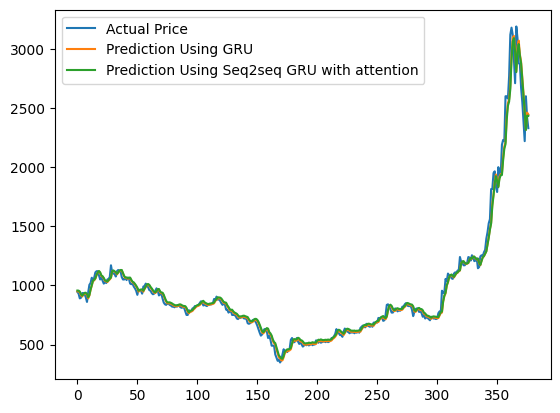

In [ ]:
price_test = np.empty_like(inv_pred_test_1)
price_test[:, :] = price[-len(inv_pred_test_1):]

plt.plot(price_test, label='Actual Price')
plt.plot(inv_pred_test_1, label='Prediction Using GRU')
plt.plot(inv_pred_test_2, label='Prediction Using Seq2seq GRU with attention')
plt.legend(loc='upper left')
plt.show()